Розничноторговая компания N требует выделить сегменты производителей темного шоколада, которым торгует данная компания. Благодяря отделу по работе с клиентами в компании был составлен обширный набор данных о темном шоколаде в формате CSV. Необходимо определить производителей с лучшим клиентским рейтингом для формирования дальнейшей продуктовой стратегии по дестребьюции темного шоколада.
Набор данных (flavors_of_cacao.csv) содержит экспертные рейтинги более 1700 отдельных шоколадных батончиков, а также наименование компании-производителя, о стране-производителе, проценте какао в шоколаде, разнообразии используемых шоколадных бобов и месте выращивания бобов. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, silhouette_score

df = pd.read_csv('flavors_of_cacao.csv', na_values='\xa0').dropna()
df = df.reset_index(drop = True)
df

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Carenero,1315,2014,70%,France,2.75,Criollo,Venezuela
1,A. Morin,Sur del Lago,1315,2014,70%,France,3.50,Criollo,Venezuela
2,A. Morin,Puerto Cabello,1319,2014,70%,France,3.75,Criollo,Venezuela
3,A. Morin,Madagascar,1011,2013,70%,France,3.00,Criollo,Madagascar
4,A. Morin,Chuao,1015,2013,70%,France,4.00,Trinitario,Venezuela
...,...,...,...,...,...,...,...,...,...
879,Zotter,El Oro,879,2012,75%,Austria,3.00,Forastero (Nacional),Ecuador
880,Zotter,Huiwani Coop,879,2012,75%,Austria,3.00,"Criollo, Trinitario",Papua New Guinea
881,Zotter,"Kongo, Highlands",883,2012,68%,Austria,3.25,Forastero,Congo
882,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo


In [2]:
#Проверям типы данных в датафрейме
df.dtypes

Company \n(Maker-if known)            object
Specific Bean Origin\nor Bar Name     object
REF                                    int64
Review\nDate                           int64
Cocoa\nPercent                        object
Company\nLocation                     object
Rating                               float64
Bean\nType                            object
Broad Bean\nOrigin                    object
dtype: object

Преобразуем данные в столбце Cocoa\nPercent в тип данных float

In [3]:
df['Cocoa%'] = df['Cocoa\nPercent'].apply(lambda x: x.replace('%', '')).astype('float')
df.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin,Cocoa%
0,A. Morin,Carenero,1315,2014,70%,France,2.75,Criollo,Venezuela,70.0
1,A. Morin,Sur del Lago,1315,2014,70%,France,3.50,Criollo,Venezuela,70.0
2,A. Morin,Puerto Cabello,1319,2014,70%,France,3.75,Criollo,Venezuela,70.0
3,A. Morin,Madagascar,1011,2013,70%,France,3.00,Criollo,Madagascar,70.0
4,A. Morin,Chuao,1015,2013,70%,France,4.00,Trinitario,Venezuela,70.0


In [4]:
#Преобразуем Review\nDate в "возраст оценки"
df['Review_time'] = 2022 - df['Review\nDate']
df.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin,Cocoa%,Review_time
0,A. Morin,Carenero,1315,2014,70%,France,2.75,Criollo,Venezuela,70.0,8
1,A. Morin,Sur del Lago,1315,2014,70%,France,3.50,Criollo,Venezuela,70.0,8
2,A. Morin,Puerto Cabello,1319,2014,70%,France,3.75,Criollo,Venezuela,70.0,8
3,A. Morin,Madagascar,1011,2013,70%,France,3.00,Criollo,Madagascar,70.0,9
4,A. Morin,Chuao,1015,2013,70%,France,4.00,Trinitario,Venezuela,70.0,9


In [5]:
print(df.iloc[:,0].nunique())
print('Уникальные значения Broad Bean\nOrigin', df['Broad Bean\nOrigin'].nunique())
print('Уникальные значения Bean\nType', df['Bean\nType'].nunique())
print('Уникальные значения Company\nLocation', df['Company\nLocation'].nunique())
print('Уникальные значения Specific Bean Origin\nor Bar Name', df['Specific Bean Origin\nor Bar Name'].nunique())

282
Уникальные значения Broad Bean
Origin 66
Уникальные значения Bean
Type 40
Уникальные значения Company
Location 50
Уникальные значения Specific Bean Origin
or Bar Name 537


Так как уникальных производителей 282, то создадим сводную таблицу по производителям. Уникальных значений текстовых признаков 
также много, поэтому при дальнейшнем пострении модели они использоваться не будут

In [6]:
table = pd.pivot_table(df, index=df.iloc[0:,0], values = ['Rating', 'Cocoa%', 'Review_time'], 
                       aggfunc={'Rating': np.mean,
                              'Cocoa%': np.mean,
                              'Review_time': np.median})
table=table.reset_index()
table

,Company \n(Maker-if known),Cocoa%,Rating,Review_time
0,A. Morin,70.000000,3.400000,8.0
1,AMMA,69.000000,3.500000,12.0
2,Acalli,70.000000,3.750000,7.0
3,Adi,75.000000,3.250000,11.0
4,Aequare (Gianduja),62.500000,2.875000,13.0
...,...,...,...,...
277,hello cocoa,65.500000,3.125000,7.0
278,hexx,74.000000,3.000000,7.0
279,iQ Chocolate,72.000000,2.750000,10.0
280,organicfair,72.666667,2.833333,9.0


<Figure size 576x432 with 0 Axes>

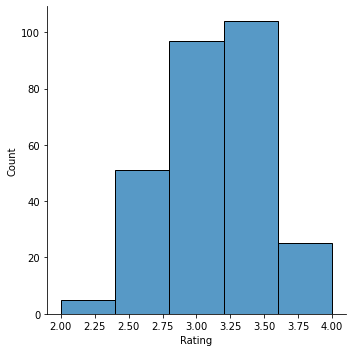

<Figure size 576x432 with 0 Axes>

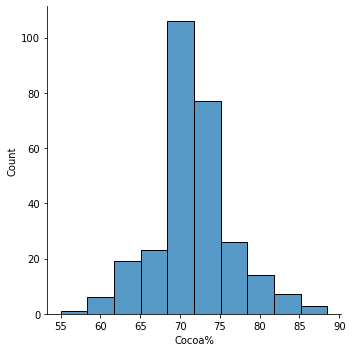

<Figure size 576x432 with 0 Axes>

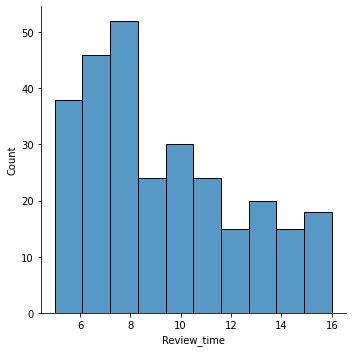

In [7]:
plt.figure(figsize=(8,6))
sns.displot(table['Rating'], bins=5)
plt.figure(figsize=(8,6))
sns.displot(table['Cocoa%'], bins=10)
plt.figure(figsize=(8,6))
sns.displot(table['Review_time'], bins=10)

Данные довольно ассиметричны. В основном весь шоколад имеет рейтинг от 3 до 3.5, также можно отметить, что подавляющее
большинство темного шоколада в датасете имеет 70-75% какао

In [8]:
analysis_data = table[['Rating', 'Cocoa%', 'Review_time']]
analysis_data

,Rating,Cocoa%,Review_time
0,3.400000,70.000000,8.0
1,3.500000,69.000000,12.0
2,3.750000,70.000000,7.0
3,3.250000,75.000000,11.0
4,2.875000,62.500000,13.0
...,...,...,...
277,3.125000,65.500000,7.0
278,3.000000,74.000000,7.0
279,2.750000,72.000000,10.0
280,2.833333,72.666667,9.0


Теперь взглянем на данные. Посмотрим матрицу корреляции для данных в таблице

In [9]:
table.corr()

,Cocoa%,Rating,Review_time
Cocoa%,1.000000,-0.064755,-0.034037
Rating,-0.064755,1.000000,-0.127870
Review_time,-0.034037,-0.127870,1.000000


Данных, которые бы сильно коррелировали между собой нет. Теперь необходимо построить матрицу объект-признак.
Для этого данные необходимо нормализовать, так как они имеют разные единицы измерения, а соответственно и разный разброс значений

In [9]:
#Предварительная обработка данных. Используем MinMaxScaler, чтобы все признаки сходились строго в диапазоне от 0 до 1
from sklearn.preprocessing import MinMaxScaler
num = MinMaxScaler().fit_transform(analysis_data)
df_num = pd.DataFrame(data = num, columns=analysis_data.columns)
df_num.head()

,Rating,Cocoa%,Review_time
0,0.7000,0.447761,0.272727
1,0.7500,0.417910,0.636364
2,0.8750,0.447761,0.181818
3,0.6250,0.597015,0.545455
4,0.4375,0.223881,0.727273


Теперь построим диаграмму рассеяния для признаков

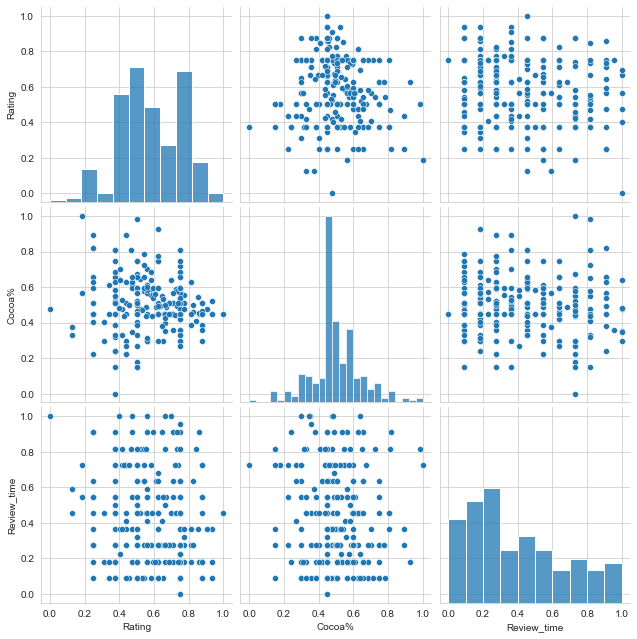

In [11]:
sns.set_style("whitegrid")
sns.pairplot(df_num, height=3);
plt.show()

На первый взгляд какие-либо четкие кластеры не определяются, посмотрим какие кластеры получатся в результате кластеризации

Также можно посмотреть на распределение данных при помощи построения диаграммы размаха (то есть ящик с усами)

<AxesSubplot:>

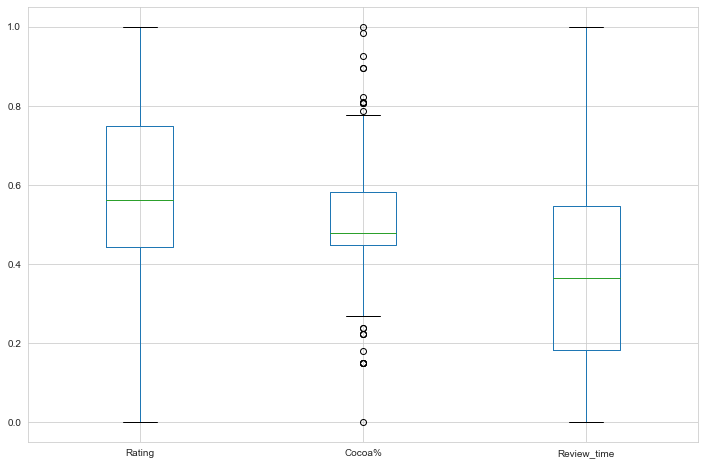

In [12]:
plt.figure(figsize=(12,8))
df_num.boxplot()

Как мы видим, теперь данные распределены в одном диапазоне, однако у признака Cocoa%, судя по диаграме размаха, имеются потенциальные выбросы. Эти данные не нужно убирать из рассмотрения, так как набор данных не очень обширный и стоит рассматривать каждый объект. Посмотрим, как наличие выбросов повлияет на модель

In [16]:
a = pd.DataFrame(table.iloc[:,0])
Matrix_object = a.join(df_num)
Matrix_object

,Company \n(Maker-if known),Rating,Cocoa%,Review_time
0,A. Morin,0.700000,0.447761,0.272727
1,AMMA,0.750000,0.417910,0.636364
2,Acalli,0.875000,0.447761,0.181818
3,Adi,0.625000,0.597015,0.545455
4,Aequare (Gianduja),0.437500,0.223881,0.727273
...,...,...,...,...
277,hello cocoa,0.562500,0.313433,0.181818
278,hexx,0.500000,0.567164,0.181818
279,iQ Chocolate,0.375000,0.507463,0.454545
280,organicfair,0.416667,0.527363,0.363636


Теперь посмотрим на матрицу объект-объект

In [14]:
import scipy
from scipy.spatial.distance import pdist, squareform
Y = pdist(df_num, 'euclidean')
Y = squareform(Y)
Obj_matrix = pd.DataFrame(data = Y).round(2)
Obj_matrix

,0,1,2,3,4,5,6,7,8,9,...,272,273,274,275,276,277,278,279,280,281
0,0.00,0.37,0.20,0.32,0.57,0.50,0.42,0.33,0.28,0.37,...,0.12,0.09,0.29,0.30,0.21,0.21,0.25,0.38,0.31,0.16
1,0.37,0.00,0.47,0.24,0.38,0.27,0.27,0.53,0.64,0.46,...,0.30,0.46,0.61,0.13,0.24,0.50,0.54,0.43,0.44,0.41
2,0.20,0.47,0.00,0.47,0.73,0.66,0.58,0.51,0.22,0.51,...,0.31,0.19,0.36,0.40,0.40,0.34,0.39,0.57,0.50,0.21
3,0.32,0.24,0.47,0.00,0.46,0.27,0.12,0.38,0.58,0.50,...,0.24,0.40,0.46,0.30,0.19,0.47,0.39,0.28,0.29,0.30
4,0.57,0.38,0.73,0.46,0.00,0.23,0.40,0.55,0.82,0.38,...,0.47,0.64,0.77,0.38,0.38,0.57,0.65,0.40,0.47,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,0.21,0.50,0.34,0.47,0.57,0.57,0.54,0.30,0.29,0.25,...,0.23,0.18,0.34,0.41,0.30,0.00,0.26,0.38,0.32,0.35
278,0.25,0.54,0.39,0.39,0.65,0.56,0.46,0.16,0.33,0.46,...,0.25,0.22,0.14,0.50,0.31,0.26,0.00,0.31,0.20,0.27
279,0.38,0.43,0.57,0.28,0.40,0.31,0.26,0.18,0.59,0.39,...,0.27,0.42,0.44,0.43,0.22,0.38,0.31,0.00,0.10,0.43
280,0.31,0.44,0.50,0.29,0.47,0.38,0.31,0.10,0.50,0.39,...,0.22,0.34,0.34,0.43,0.21,0.32,0.20,0.10,0.00,0.35


In [15]:
Z = Obj_matrix * Obj_matrix
Z

,0,1,2,3,4,5,6,7,8,9,...,272,273,274,275,276,277,278,279,280,281
0,0.0000,0.1369,0.0400,0.1024,0.3249,0.2500,0.1764,0.1089,0.0784,0.1369,...,0.0144,0.0081,0.0841,0.0900,0.0441,0.0441,0.0625,0.1444,0.0961,0.0256
1,0.1369,0.0000,0.2209,0.0576,0.1444,0.0729,0.0729,0.2809,0.4096,0.2116,...,0.0900,0.2116,0.3721,0.0169,0.0576,0.2500,0.2916,0.1849,0.1936,0.1681
2,0.0400,0.2209,0.0000,0.2209,0.5329,0.4356,0.3364,0.2601,0.0484,0.2601,...,0.0961,0.0361,0.1296,0.1600,0.1600,0.1156,0.1521,0.3249,0.2500,0.0441
3,0.1024,0.0576,0.2209,0.0000,0.2116,0.0729,0.0144,0.1444,0.3364,0.2500,...,0.0576,0.1600,0.2116,0.0900,0.0361,0.2209,0.1521,0.0784,0.0841,0.0900
4,0.3249,0.1444,0.5329,0.2116,0.0000,0.0529,0.1600,0.3025,0.6724,0.1444,...,0.2209,0.4096,0.5929,0.1444,0.1444,0.3249,0.4225,0.1600,0.2209,0.4489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,0.0441,0.2500,0.1156,0.2209,0.3249,0.3249,0.2916,0.0900,0.0841,0.0625,...,0.0529,0.0324,0.1156,0.1681,0.0900,0.0000,0.0676,0.1444,0.1024,0.1225
278,0.0625,0.2916,0.1521,0.1521,0.4225,0.3136,0.2116,0.0256,0.1089,0.2116,...,0.0625,0.0484,0.0196,0.2500,0.0961,0.0676,0.0000,0.0961,0.0400,0.0729
279,0.1444,0.1849,0.3249,0.0784,0.1600,0.0961,0.0676,0.0324,0.3481,0.1521,...,0.0729,0.1764,0.1936,0.1849,0.0484,0.1444,0.0961,0.0000,0.0100,0.1849
280,0.0961,0.1936,0.2500,0.0841,0.2209,0.1444,0.0961,0.0100,0.2500,0.1521,...,0.0484,0.1156,0.1156,0.1849,0.0441,0.1024,0.0400,0.0100,0.0000,0.1225


In [16]:
max_by_columns = Z.max()
max_by_rows = Z.max(axis=1)

df_max = max(max_by_columns)
print("Max element based on the list of columns: ", df_max)

df_max2 = max(max_by_rows)
print("Max element based on the list of rows: ", df_max2)

Max element based on the list of columns:  1.7161000000000002
Max element based on the list of rows:  1.7161000000000002


Для дальнейшей кластеризации будем использовать метод распространения близости. Его идея заключается в том, что точки обмениваются
сообщениями между собой и на основе этого создаются кластеры. Для данного метода явно нельзя ограничить количество кластеров, но
можно ограничить количество итераций. Также можно задать коэффициент сглаживания (от 0.5 до 1), чем данный коэффициент больше,
тем меньше кластеров, и можно задать такой параметр, как preference, который говорит о "похожести" точек.
Для начала определим оптимальное количество кластеров при помощи метода локтя

C:\Users\Aleksey\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


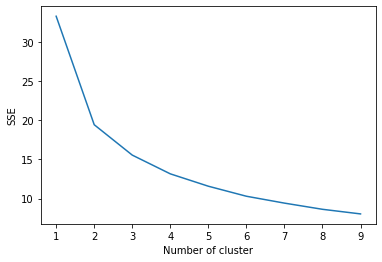

In [10]:
from sklearn.cluster import KMeans
data1 = df_num

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data1)
    data1["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Таким образом, можно сказать, что оптимальное число кластеров равно 4, а может быть и 2

Также можно оценить силуэтный индекс, чтобы определиться с оптимальным количеством кластеров

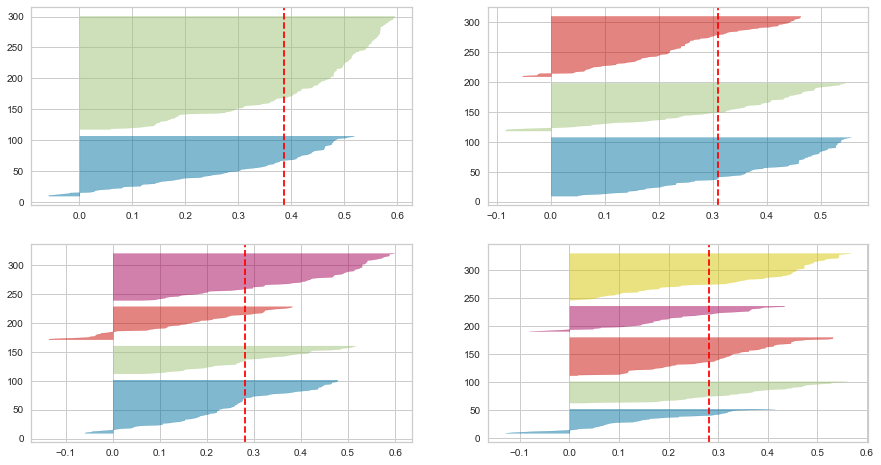

In [11]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

data2 = df_num
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data2)

В данном случае видно, что силуэтный индекс для количества кластеров равному 4 равен примерно 0,27, аналогчино и для k=3 и k=5. Больше всего силуэтный индекс для k=2 (почти 0,4), однако, как уже было отмечено ранее, k=2 в данном случае не позволит хорошо сегментировать данные, поэтому будем считать k=4 оптимальным количеством кластеров. Также стоит отметить близость силуэтного индекса к 0, что говорит о том, что кластеры перекрываются

In [13]:
#Affinity propagation, в качестве preference подаем максимальное евклидова расстояние, умноженное на -1
model_data = df_num
affinity = AffinityPropagation(damping = 0.98, max_iter = 1000, preference = -1.71).fit(model_data)
centers = affinity.cluster_centers_
labels = affinity.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
score = silhouette_score(model_data, labels, metric='euclidean')
print('Количество кластеров:', n_clusters_)
print(centers)
print('Силуэт =', score)

Количество кластеров: 4
[[0.4375     0.44776119 0.27272727]
 [0.525      0.47761194 0.81818182]
 [0.67105263 0.48703849 0.54545455]
 [0.73611111 0.50746269 0.18181818]]
Силуэт = 0.276068466825664


Таким образом, было получено 4 кластера

In [14]:
d = pd.DataFrame(labels)
table = table.join(d)
table = table.rename(columns={0:'Cluster'})
table

,Company \n(Maker-if known),Cocoa%,Rating,Review_time,Cluster
0,A. Morin,70.000000,3.400000,8.0,3
1,AMMA,69.000000,3.500000,12.0,2
2,Acalli,70.000000,3.750000,7.0,3
3,Adi,75.000000,3.250000,11.0,2
4,Aequare (Gianduja),62.500000,2.875000,13.0,1
...,...,...,...,...,...
277,hello cocoa,65.500000,3.125000,7.0,0
278,hexx,74.000000,3.000000,7.0,0
279,iQ Chocolate,72.000000,2.750000,10.0,0
280,organicfair,72.666667,2.833333,9.0,0


Посмотрим на количество элементов в кластере

In [17]:
Matrix_object = Matrix_object.join(d)
Matrix_object = Matrix_object.rename(columns={0:'Cluster'})

Matrix_object['Cluster'].value_counts()

0    90
3    84
2    55
1    53
Name: Cluster, dtype: int64

In [18]:
df_clusters = table.groupby('Cluster')['Rating','Cocoa%']
df_clusters.describe()

C:\Users\Aleksey\AppData\Local\Temp/ipykernel_6236/1185263024.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_clusters = table.groupby('Cluster')['Rating','Cocoa%']


Rating                                                          \
         count      mean       std   min       25%       50%       75%   
Cluster                                                                  
0         90.0  2.832454  0.206777  2.25  2.750000  2.875000  3.000000   
1         53.0  2.999690  0.333998  2.00  2.750000  3.000000  3.166667   
2         55.0  3.355649  0.250190  2.75  3.151786  3.342105  3.500000   
3         84.0  3.451258  0.193154  3.00  3.293182  3.500000  3.500000   

                 Cocoa%                                              \
             max  count       mean       std   min   25%        50%   
Cluster                                                               
0        3.25000   90.0  71.235185  4.872638  60.0  70.0  70.333333   
1        3.71875   53.0  71.213727  6.531253  55.0  67.0  71.000000   
2        4.00000   55.0  71.621454  3.873871  64.0  70.0  71.294118   
3        3.87500   84.0  72.440309  3.988498  65.0  70.0  71.000000   

                          
               75%   max  
Cluster                   
0        74.000000  85.0  
1        74.428571  88.5  
2        74.837500  80.0  
3        74.270833  86.0

In [19]:
df_clusters2 = table.groupby('Cluster')['Review_time']
df_clusters2.describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,90.0,8.000000,1.459182,6.0,7.0,8.0,9.0,11.5
1,53.0,14.009434,1.153967,12.0,13.0,14.0,15.0,16.0
2,55.0,10.872727,1.068133,9.0,10.0,11.0,12.0,13.0
3,84.0,7.214286,0.970299,5.0,6.0,7.0,8.0,9.0


Посмотрим на распределение данных в кластерах. Для этого построим диаграмму "ящик с усами" для каждого кластера и соответствующего признака

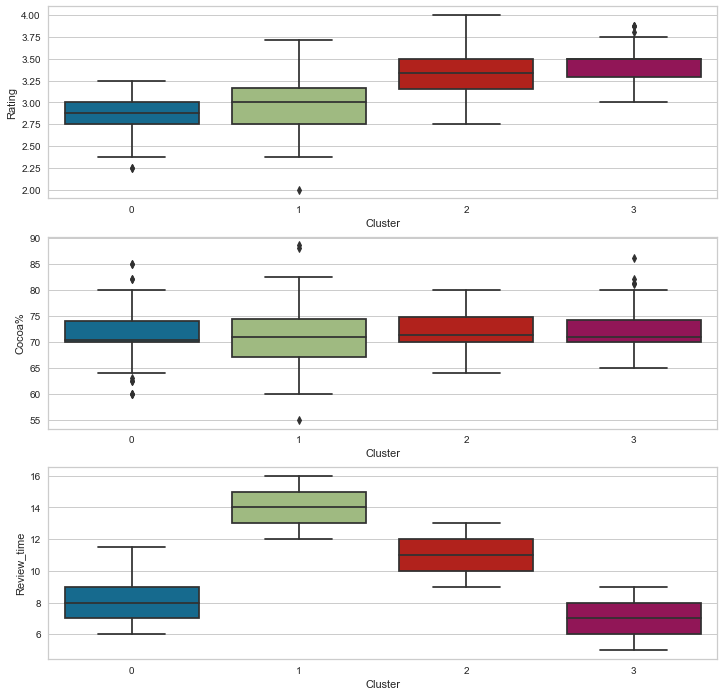

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [20]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows = 3,figsize=(12,12))

plt.figure(figsize=(12,8))
plot1 = sns.boxplot(x=table['Cluster'],y=table['Rating'],data=table, ax = ax1)

plt.figure(figsize=(12,8))
plot2 = sns.boxplot(x=table['Cluster'],y=table['Cocoa%'],data=table, ax= ax2)
plt.figure(figsize=(12,8))
plot2 = sns.boxplot(x=table['Cluster'],y=table['Review_time'],data=table, ax= ax3)

По результатам распределения данных в кластерах видно следующее: 
1. По проценту содержания какао в шоколаде производителей кластеры между собой мало чем отличаются. Средний процент какао в каждом кластере практически одинаковый.
2. Наибольший рейтинг имеет шоколад, производители которого находится во втором и третьем кластерах, при этом отчеты по шоколаду из третьего кластера наиболее новые по сравнению со вторым кластером.
3. Самым плохим по рейтингу можно назвать кластер 0, при этом возраст отчетов по шоколаду от производителей из этого кластера почти совпадает с возрастом отчетов из самого "лучшего" кластера - 3.
4. К производителям из кластера 1 также лучше не стоит присматриваться, так как отзывы на шоколад этих производителей являются устаревшими

In [21]:
display(Matrix_object.head())
print(centers)

,Company \n(Maker-if known),Rating,Cocoa%,Review_time,Cluster
0,A. Morin,0.7000,0.447761,0.272727,3
1,AMMA,0.7500,0.417910,0.636364,2
2,Acalli,0.8750,0.447761,0.181818,3
3,Adi,0.6250,0.597015,0.545455,2
4,Aequare (Gianduja),0.4375,0.223881,0.727273,1


[[0.4375     0.44776119 0.27272727]
 [0.525      0.47761194 0.81818182]
 [0.67105263 0.48703849 0.54545455]
 [0.73611111 0.50746269 0.18181818]]


Далее идет визуализация результатов кластерного анализа

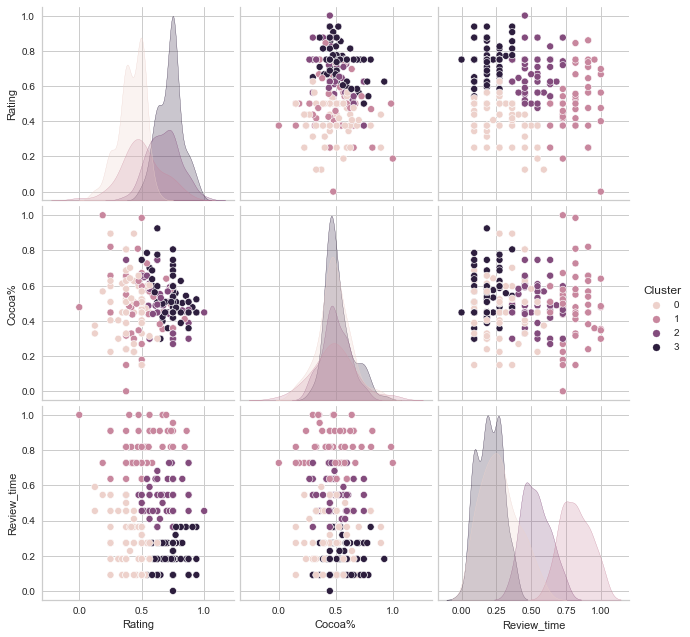

In [22]:
sns.set_style("whitegrid")
sns.pairplot(Matrix_object, hue = 'Cluster', height=3);
plt.show()

Стоит отметить, что в кластеры также попали достаточно удаленные точки, что связано с особенностью работы метода AP, который даже удаленные от кластеров точки включает в ближайшие к ним кластеры

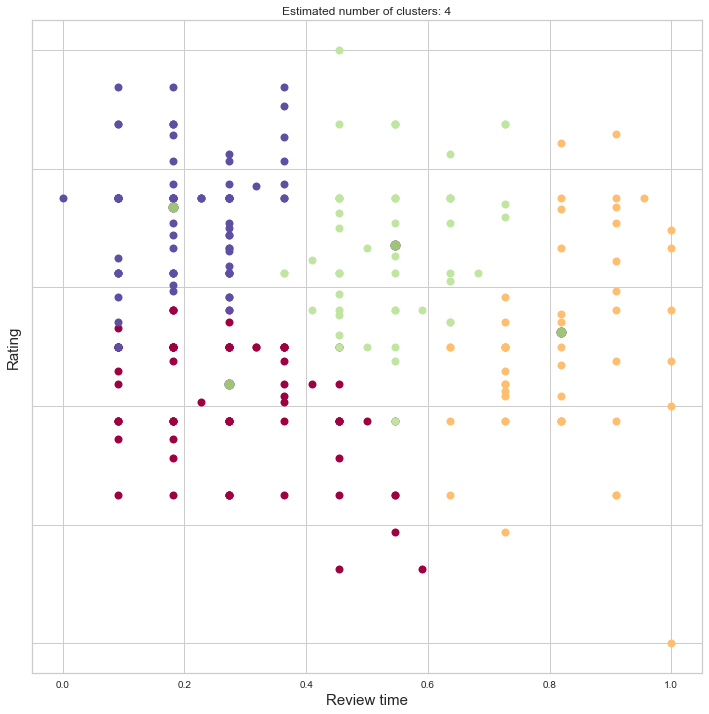

In [23]:
plt.figure(figsize=(12,12))
X = Matrix_object
core_samples_mask = np.zeros_like(affinity.labels_, dtype=bool)
centers

# Company \n(Maker-if known)	Rating	Cocoa%	Review_time	Cluster

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 3], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=8)
    plt.plot(centers[:, 2] , centers[:, 0] , 'o', markeredgecolor = 'g', markersize=10)
    ax = plt.gca()
    ax.set_xlabel('Review time', fontsize=15)
    ax.set_ylabel('Rating', fontsize=15)
    ax.axes.yaxis.set_ticklabels([])

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

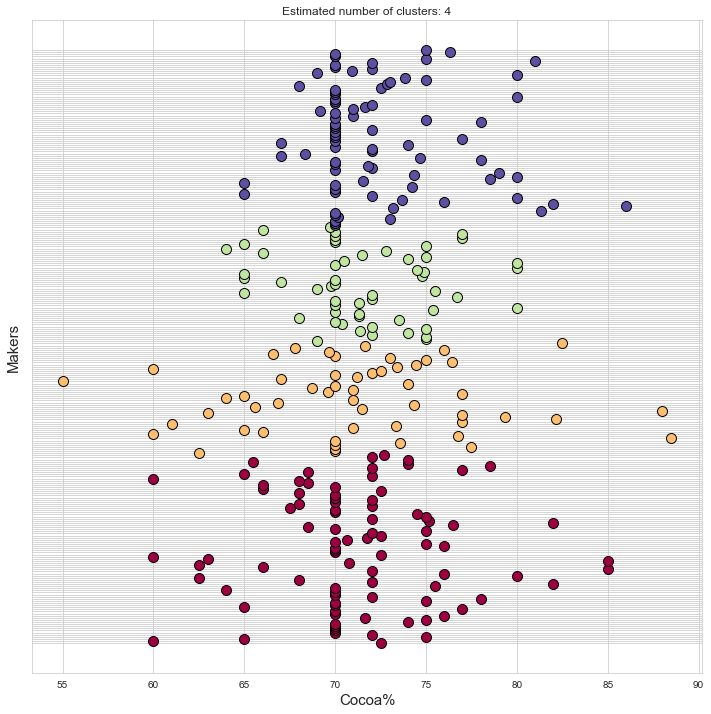

In [33]:
plt.figure(figsize=(12,12))
X = table
core_samples_mask = np.zeros_like(affinity.labels_, dtype=bool)

# analysis_data = table[['Company_label', 'Rating', 'Cocoa%', 'Company_Location_label', 
#                      'Bean_origin_label', 'Bean_type', 'Review_time']]

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 1], xy.iloc[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10)
    ax = plt.gca()
    ax.set_xlabel('Cocoa%', fontsize=15)
    ax.set_ylabel('Makers', fontsize=15)
    ax.axes.yaxis.set_ticklabels([])

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

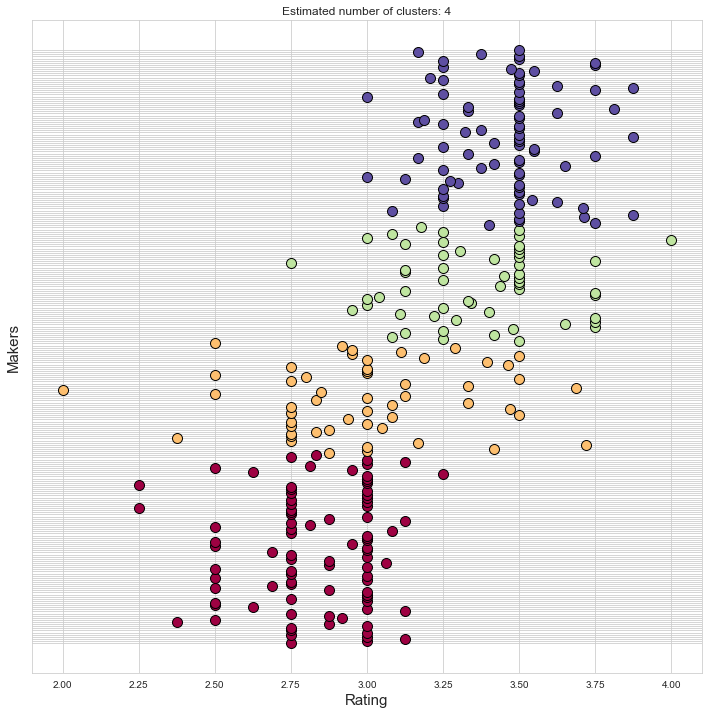

In [34]:
plt.figure(figsize=(12,12))
X = table
core_samples_mask = np.zeros_like(affinity.labels_, dtype=bool)

# analysis_data = table[['Company_label', 'Rating', 'Cocoa%', 'Company_Location_label', 
#                      'Bean_origin_label', 'Bean_type', 'Review_time']]

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 2], xy.iloc[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10)
    ax = plt.gca()
    ax.set_xlabel('Rating', fontsize=15)
    ax.set_ylabel('Makers', fontsize=15)
    ax.axes.yaxis.set_ticklabels([])

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

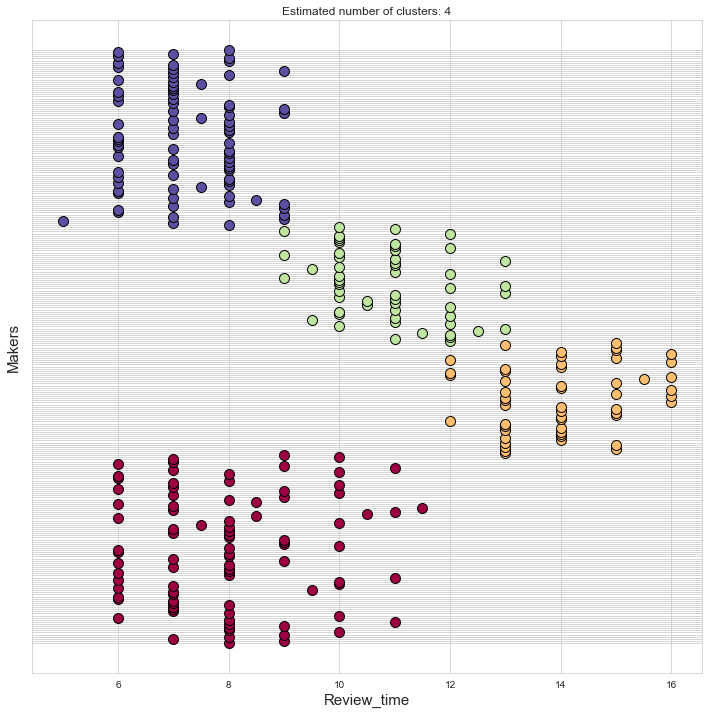

In [35]:
plt.figure(figsize=(12,12))
X = table
core_samples_mask = np.zeros_like(affinity.labels_, dtype=bool)

# analysis_data = table[['Company_label', 'Rating', 'Cocoa%', 'Company_Location_label', 
#                      'Bean_origin_label', 'Bean_type', 'Review_time']]

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 3], xy.iloc[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10)
    ax = plt.gca()
    ax.set_xlabel('Review_time', fontsize=15)
    ax.set_ylabel('Makers', fontsize=15)
    ax.axes.yaxis.set_ticklabels([])

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()